In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import cv2
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.metrics import categorical_crossentropy
from keras.optimizers import SGD
from keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split

In [2]:
def Alexnet():
    # Initialize the model
    model = Sequential()

    # Layer 1: Convolutional layer + Max-pooling layer
    model.add(Conv2D(filters=96, kernel_size=(11, 11), strides=4, padding='valid', activation='relu', input_shape=(227, 227, 3)))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Layer 2: Convolutional layer + Max-pooling layer
    model.add(Conv2D(filters=256, kernel_size=(5, 5), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Layers 3-5: Three convolutional layers + 1 max-pooling layer
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=384, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'))
    model.add(MaxPooling2D(pool_size=(3, 3), strides=2))

    # Layers 6-8: Two fully connected hidden layers and one fully connected output layer
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation='softmax'))  # Adjust the number of classes here

    # Compile the model with a loss function, a metric, and an optimizer method for estimating the loss function
    opt = SGD(learning_rate=0.01)
    model.compile(loss=categorical_crossentropy, optimizer=opt, metrics=['accuracy'])

    return model

In [3]:
train_path = 'E:/Gastro Intestine/kvasir-dataset/kvasir-dataset'
test_path = 'E:/Gastro Intestine/kvasir-dataset/kvasir-dataset'

In [4]:
print('The training set consists of:\n', 
      len(os.listdir(train_path + '/eso/')), ' eso images\n',
      len(os.listdir(train_path + '/norm/')), 'norm images\n',
      len(os.listdir(train_path + '/poly/')), ' poly images\n',
      len(os.listdir(train_path + '/ulcer/')), ' ulcer images\n')

The training set consists of:
 500  eso images
 500 norm images
 500  poly images
 500  ulcer images



In [5]:
cates = ['/eso', '/norm', '/poly', '/ulcer']

In [6]:
def load_images_and_labels(data_path, cates):
    X = []
    y = []
    for index, cate in enumerate(cates):
        for img_name in os.listdir(data_path + cate + '/'):
            img = cv2.imread(data_path + cate + '/' + img_name)
            if img is not None:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                img_array = Image.fromarray(img, 'RGB')
                img_rs = img_array.resize((227, 227))
                img_rs = np.array(img_rs)
                X.append(img_rs)
                y.append(index)
    return X, y

In [7]:
X_train, y_train = load_images_and_labels(train_path, cates)
X_test, y_test = load_images_and_labels(test_path, cates)

In [8]:
data_dict = {'X_train': X_train, 'y_train': y_train, 'X_test': X_test, 'y_test': y_test}
np.save('data_dict.npy', data_dict)

In [9]:
data_dict_ = np.load('data_dict.npy', allow_pickle=True).item()
X_train = data_dict_['X_train']
y_train = data_dict_['y_train']
X_test = data_dict_['X_test']
y_test = data_dict_['y_test']

plt.figure(figsize=(12, 7))

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

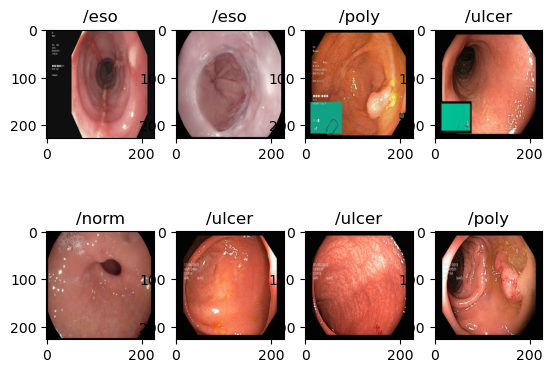

In [10]:
for i in range(8):
    ind = random.randint(0, len(X_train) - 1)
    plt.subplot(240 + 1 + i)
    plt.imshow(X_train[ind])
    plt.title(cates[y_train[ind]])

In [11]:
def preprocess_data(X, y):
    X = np.array(X).astype(np.float32) / 255.0
    y = to_categorical(np.array(y))
    return X, y

In [12]:
X_train, y_train = preprocess_data(X_train, y_train)
X_test, y_test = preprocess_data(X_test, y_test)

plt.figure(figsize=(12, 7))

<Figure size 1200x700 with 0 Axes>

<Figure size 1200x700 with 0 Axes>

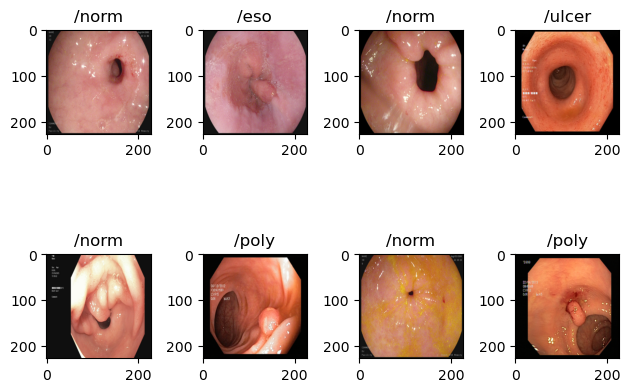

In [13]:
for i in range(8):
    ind = random.randint(0, len(X_train) - 1)
    plt.subplot(240 + 1 + i)
    plt.imshow(X_train[ind])
    plt.title(cates[np.argmax(y_train[ind])])

plt.tight_layout()
plt.show()

In [14]:
def train_model(model, X_train, y_train, X_test, y_test, epochs, batch_size):
    datagen = ImageDataGenerator(rotation_range=5, width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
    it_train = datagen.flow(X_train, y_train, batch_size=batch_size)
    path_cp = os.path.join(os.getcwd(), 'weights_.keras')
    checkpoint_ = ModelCheckpoint(path_cp, monitor='loss', save_best_only=True, mode='auto')
    steps = X_train.shape[0] // batch_size
    history = model.fit(it_train, epochs=epochs, steps_per_epoch=steps, validation_data=(X_test, y_test), verbose=1, callbacks=[checkpoint_])
    _, acc = model.evaluate(X_test, y_test, verbose=1)
    print('%.3f' % (acc * 100.0))
    return history, acc

In [15]:
input_shape = (227, 227, 3)
num_classes = 4

In [16]:
Alexnet_model = Alexnet()
Alexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

train_history, acc = train_model(Alexnet_model, X_train, y_train, X_test, y_test, epochs=10, batch_size=128)

C:\Users\Ritvik Sharma\AppData\Roaming\Python\Python310\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/10


C:\Users\Ritvik Sharma\AppData\Roaming\Python\Python310\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.2484 - loss: 3.0982

OSError: [Errno 28] No space left on device

In [1]:
def plot_accuracy(history):
  plt.figure(figsize = (10,6))
  plt.plot(history.history['accuracy'], color = 'blue', label = 'train')
  plt.plot(history.history['val_accuracy'], color = 'red', label = 'val')
  plt.legend()
  plt.title('Accuracy')
  plt.show()
  
plot_accuracy(train_history)

NameError: name 'train_history' is not defined

In [2]:

y_test_pred = []
for i in np.arange(len(X_test)):
  img = X_test[i]
  img = img.reshape(1, 227, 227, 3)
  y_p = Alexnet_model.predict(img)
  y_test_pred.append(y_p)

y_test_pred = np.asarray(y_test_pred)

NameError: name 'np' is not defined

In [3]:
from sklearn.metrics import confusion_matrix
import seaborn as sns 

# Reverse the true and the predicted labels into the original binary 
# labels (0 and 1) to compute the confusion matrix
y_test_labels = [np.argmax(vect) for vect in y_test]
y_test_pred_labels = [np.argmax(vect) for vect in y_test_pred]

conf_mat = confusion_matrix(y_test_labels, y_test_pred_labels)

plt.figure(figsize = (10,8))
sns.heatmap(conf_mat, linewidths = 0.1, cmap = 'Greens', linecolor = 'gray', 
            fmt = '.1f', annot = True)
plt.xlabel('Predicted classes', fontsize = 20)
plt.ylabel('True classes', fontsize = 20)

NameError: name 'y_test' is not defined

In [ ]:
plt.figure(figsize = (15,8))
for i in np.arange(8):
  # take randomly an indice
  ind = random.randint(0, len(X_test))
  img = X_test[ind]
  # reshape the image 
  img_rs = img.reshape(1,227,227,3)
  # predict the label of img
  y_pred = Alexnet_model.predict(img_rs)
  # determine the corresponding category
  predicted_cate = cates[np.argmax(y_pred)]
  plt.subplot(240+1+i)
  plt.imshow(img)
  plt.title('predicted: ' + str(predicted_cate))